# Anomaly detection in Industrial Manufacturing 

This project is on the application of data science and machine learning to a problem in manufacturing. Detecting anomalies during metal machining, using a variational autoencoder (VAE). Although this application is manufacturing specific, the principals can be used whenever anomaly detection is useful. 

In this document, we'll review:
    - Anomaly detection, intriducing the data, and and do some exploratory data analysis, 
    - After covering some theory of variational autoencoder, we'll build and train VAEs using TensorFlow,
    - Trained VAEs will be used for anomaly detection, abd some data visualization are presented to better understand       the results.
    

# Setup Notebook

In [1]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

import h5py
import zipfile

from IPython.display import clear_output, display #clears the ouptput if needed

import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import (confusion_matrix,
                            roc_auc_score,
                            roc_curve,
                            precision_recall_curve,
                            auc,
                            )

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback

%matplotlib inline

In [2]:
cwd = Path.cwd()

In [3]:
folder_raw_data = Path('data/raw/')  #raw data folder that holds the zip  .mat files for milling data
folder_processed_data = Path('data/processed/')  # processed data folder
folder_models = Path('models/')  # folder for saved models

In [4]:
# exctract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data/ 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

In [5]:
#extract best models from the zip file
with zipfile.ZipFile(folder_models/ 'best_models' / 'best_models.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_models / 'best_models')

In [6]:
# simple functions used in the data prep

def scaler(x, min_val_array, max_val_array):  #come back to this and check 
    '''
    Function to scale the data with min-max values
    '''

    # get the shape of the array
    s, _, sub_s = np.shape(x)  #what x looks like?

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x

#min-max function
def get_min_max(x):
    flat_vector = np.concatenate(x) #flatten the input array
    
    min_vals = np.min(flat_vector, axis = 0)
    max_vals = np.max(flat_vector, axis = 0)
    
    return min_vals, max_vals

def load_train_test(directory): #function to quickly load the train/val/test data splits
    
    path = directory

    with h5py.File(path / "X_train.hdf5", "r") as f:  #review HDF5 with python 
        X_train = f["X_train"][:]
    with h5py.File(path / "y_train.hdf5", "r") as f:
        y_train = f["y_train"][:]

    with h5py.File(path / "X_train_slim.hdf5", "r") as f:
        X_train_slim = f["X_train_slim"][:]
    with h5py.File(path / "y_train_slim.hdf5", "r") as f:
        y_train_slim = f["y_train_slim"][:]

    with h5py.File(path / "X_val.hdf5", "r") as f:
        X_val = f["X_val"][:]
    with h5py.File(path / "y_val.hdf5", "r") as f:
        y_val = f["y_val"][:]

    with h5py.File(path / "X_val_slim.hdf5", "r") as f:
        X_val_slim = f["X_val_slim"][:]
    with h5py.File(path / "y_val_slim.hdf5", "r") as f:
        y_val_slim = f["y_val_slim"][:]

    with h5py.File(path / "X_test.hdf5", "r") as f:
        X_test = f["X_test"][:]
    with h5py.File(path / "y_test.hdf5", "r") as f:
        y_test = f["y_test"][:]

    return (
        X_train,
        y_train,
        X_train_slim,
        y_train_slim,
        X_val,
        y_val,
        X_val_slim,
        y_val_slim,
        X_test,
        y_test,
    )

#functions for model training
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
#rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))
    

# 1. Data Exploration

First step is understanding hoe the data is structured. How it is stored: In a database? Or in an array? Where is the meta-data (things like labels and time-stamps)?

Milling data here is contained in a structured MATLAB array. Which is loaded here using scipy.io module and the laodmat function here:

In [7]:
#load data from matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat', struct_as_record = True)

#The data is stored in a dictionary. Only the 'mill' key contains useful information.
#store the 'mill' data in a separate np array
data = m['mill']

In [8]:
#show some of the info from matlab file
print('Keys in the matlab dict file: \n', m.keys(), '\n')

#store the field names (name of the columns) in the data np array in a tuple, l:
l = data.dtype.names
print('List of the field names:\n', l)

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


# Meta-Data and Labels

The data set is made of 16 cases of milling tools performing cuts in metal. Six cutting parameters were used in the creation of the data:
    1. the metal type (either cast iron or steel, labelled as 1 or 2 in the data set, respectively)
    2. the depth of cut (either 0.75 mm or 1.5 mm)
    3. the feed rate (either 0.25 mm/rev or 0.5 mm/rev)
Each of the 16 cases is a combination of the cutting parameters (for example, case one has a depth of cut of 1.5 mm, a feed rate of 0.5 mm/rev, and is performed on cast iron).
The cases are made up of individual cuts from when the tool is new to degraded or worn. There are 167 cuts (called ‘runs’ in the documentation) amongst all 16 cases. Many of the cuts are accompanied by a measure of flank wear (VB). We’ll use this later to label the cuts as either healthy, degraded, or worn.
Finally, six signals were collected during each cut:
    4. Acoustic emission (AE) signals from the spindle and table.
    5. Vibration from the spindle and table.
    6. AC/DC current from the spindle motor.
The signals were collected at 250 Hz and each cut had 9000 sampling points, for a total signal length of 36 seconds.
We will extract the meta-data and labels from the numpy array and store it as a pandas dataframe — we’ll call this dataframe df_labels since it contains the label information we’ll be interested in. This is how we create the dataframe:

In [9]:
#create empty dataFrame for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put it in dataframe
for i in range(7): #we only need 7 of the columns
    #list for sorting the label data for each field
    x = []
    
    #iterate through each of the unique cuts
    for j in range(167): #data collected for 167 cuts
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x
    
#add column names to the dataframe
df_labels.columns = l[0:7]

#create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


In the above table, from df_labels.head(), it can be seen that not all cuts are labelled with a flank wear (VB) value. Later, we’ll be setting categories for the tool health — either healthy, degraded, or worn (failed). We can reasonably estimate the tool health categories, based on nearby cuts that have wear values, for cuts without a flank wear (VB) value.

# Data visualization

Make a simple plot to look at the some of the data, below is cut 167 as an example

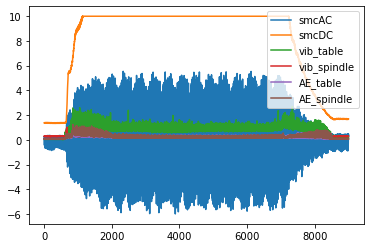

In [10]:
cut_no = 166
fig, ax = plt.subplots()

ax.plot(data[0,cut_no]['smcAC'], label='smcAC')
ax.plot(data[0,cut_no]['smcDC'], label='smcDC')
ax.plot(data[0,cut_no]['vib_table'], label='vib_table')
ax.plot(data[0,cut_no]['vib_spindle'], label='vib_spindle')
ax.plot(data[0,cut_no]['AE_table'], label='AE_table')
ax.plot(data[0,cut_no]['AE_spindle'], label='AE_spindle')

plt.legend()
plt.show()

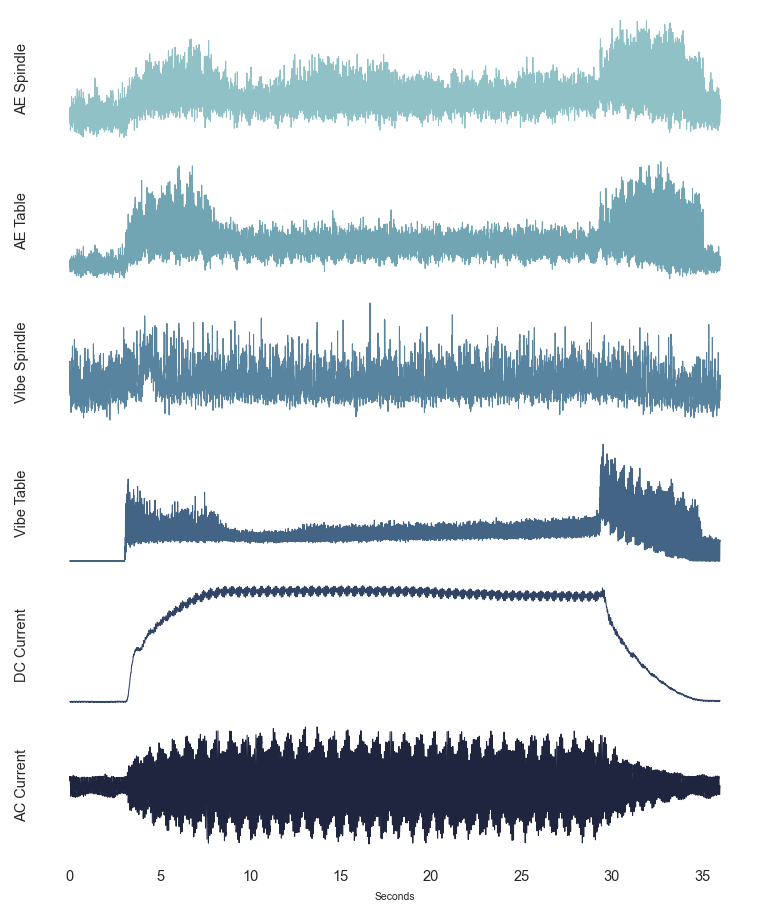

In [11]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,9000)/250.0, 
                     cut_signal[signals_trend[i]], 
                     color=pal[i], 
                     linewidth=0.5, 
                     alpha=1)
        
        axis_label = signal_names_revised[i]
        
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly
        
        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[::-1]  # reverse the signal order so that it is matching other charts

# we'll plot signal 146 (index 145)
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_146")
# plt.savefig('cut_signals.png',format='png') # save the figure
plt.show()

# 2. Data Prep

Now, we need tomprepare the data. First we need to label the data. As explained earlier, each cut has an associated amount of flank wear, VB, measured at the end of the cut. Here, we'll label each cut as either healthy, degraded, or failed according to the amount of wear on the tool. These are the tool health category. 

In [12]:
import data_prep

In [13]:
data_file = folder_raw_data / "mill.mat"

In [14]:
prep = data_prep.DataPrep(data_file)

In [15]:
# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)

exploring dataset in previous section, we saw two cuts are strange, cuts 17 and 94, so we discard them:

In [16]:
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace = True)

In [17]:
X, y, dfy = prep.return_xy(df_labels, prep.data,prep.field_names[7:],window_size=64, stride=64, track_y=True)

In [18]:
X_train, X_test, dfy_train, dfy_test = train_test_split(X, dfy, test_size=0.33, random_state=15, 
                                                    stratify=dfy['class'])

In [19]:
X_val, X_test, dfy_val, dfy_test = train_test_split(X_test, dfy_test, test_size=0.50, random_state=10, 
                                                stratify=dfy_test['class'])

In [20]:
dfy

,class,counter,case
0,0.0,0.0000,1.0
1,0.0,0.0001,1.0
2,0.0,0.0002,1.0
3,0.0,0.0003,1.0
4,0.0,0.0004,1.0
...,...,...,...
11565,1.0,166.0061,16.0
11566,1.0,166.0062,16.0
11567,1.0,166.0063,16.0
11568,1.0,166.0064,16.0


class column to int:

In [21]:
y_train = dfy_train['class'].to_numpy(dtype='int')
y_val = dfy_val['class'].to_numpy(dtype='int')
y_test = dfy_test['class'].to_numpy(dtype='int')

In [22]:
min_vals, max_vals = get_min_max(X_train)

In [23]:
#scale the datasets using the fubction that we defined

In [24]:
X = scaler(X, min_vals, max_vals)
X_train = scaler(X_train, min_vals, max_vals)
X_val = scaler(X_val, min_vals, max_vals)
X_test = scaler(X_test, min_vals, max_vals)

printing some more info about the datasets

In [25]:
print('Min/max values from X_train:')
print(min_vals)
print(max_vals)

Min/max values from X_train:
[-6.96777344  3.41796875  0.20263672  0.21850586  0.01464844  0.09094238]
[6.77734375 9.99511719 2.84423828 0.96801758 0.59082031 0.90026855]


In [26]:
print("\nShape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("\nShape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (7751, 64, 6)
Shape of y_train: (7751,)

Shape of X_val: (1909, 64, 6)
Shape of y_val: (1909,)

Shape of X_test: (1910, 64, 6)
Shape of y_test: (1910,)


Slim down the X_train and X_val by removing classes 1 and 2

In [27]:
X_train_slim, y_train_slim = prep.remove_classes([1, 2], y_train, X_train)

print("\nShape of X_train_slim:", X_train_slim.shape)
print("Shape of y_train_slim:", y_train_slim.shape)

X_val_slim, y_val_slim = prep.remove_classes([1, 2], y_val, X_val)

print("\nShape of X_val_slim:", X_val_slim.shape)
print("Shape of y_val_slim:", y_val_slim.shape)

signal_names = prep.field_names[7:] # get signal names
signal_names = signal_names[::-1] # reverse order so that it is same as in data structure


Shape of X_train_slim: (2831, 64, 6)
Shape of y_train_slim: (2831,)

Shape of X_val_slim: (697, 64, 6)
Shape of y_val_slim: (697,)


For anomaly detection, it is common to train the autoencoders on “normal” data only. We’ll be doing the same and training our VAE on healthy data (class 0). However, checking the performance of the anomaly detection will be completed using all the data. In other words, we’ll be training our VAE on the “slim” data sets, but testing on the “full” data sets.

Save the data splits in the processed data folder (also save the "slimmed" down versions of the X_train and X_val).

In [28]:
# X_train, y_train
with h5py.File("data/processed/X_train.hdf5", "w") as f:
    dset = f.create_dataset("X_train", data=X_train)
with h5py.File("data/processed/y_train.hdf5", "w") as f:
    dset = f.create_dataset("y_train", data=y_train)

# X_val, y_val
with h5py.File("data/processed/X_val.hdf5", "w") as f:
    dset = f.create_dataset("X_val", data=X_val)
with h5py.File("data/processed/y_val.hdf5", "w") as f:
    dset = f.create_dataset("y_val", data=y_val)

# X_test, y_test
with h5py.File("data/processed/X_test.hdf5", "w") as f:
    dset = f.create_dataset("X_test", data=X_test)
with h5py.File("data/processed/y_test.hdf5", "w") as f:
    dset = f.create_dataset("y_test", data=y_test)


with h5py.File("data/processed/X_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_train_slim", data=X_train_slim)
with h5py.File("data/processed/y_train_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_train_slim", data=y_train_slim)

with h5py.File("data/processed/X_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("X_val_slim", data=X_val_slim)
with h5py.File("data/processed/y_val_slim.hdf5", "w") as f:
    dset = f.create_dataset("y_val_slim", data=y_val_slim)

# 3. Train Models

Data is prepared, time to begin training models. To select the hyperparameters, we'll be using a random search. Because it is fairly simple to implement and has beed shown to yield good results when compared to grid search. Scikit-learn has some nice methods for implementing a random search. 

We'll be training a couple of different VAEs, all with different parameters. After each VAE has been trained (to minimize the reconstruction loss), and the model saved, we'll go through the model and see how it performed in anomaly detection. 

Input Space Anomaly Detection:
Our variational autoencoders have been trained on “healthy” tool wear data. As such, if we feed the trained VAEs unhealthy data, or simply abnormal, we should generate a large reconstruction error. A threshold can be set on this reconstruction error, whereby data producing a reconstruction error above the threshold is considered an anomaly. This is input space anomaly detection.

Our variational autoencoders have been trained on “healthy” tool wear data. As such, if we feed the trained VAEs unhealthy data, or simply abnormal, we should generate a large reconstruction error. A threshold can be set on this reconstruction error, whereby data producing a reconstruction error above the threshold is considered an anomaly. This is input space anomaly detection.

We’ll measure the reconstruction error using mean-squared-error (MSE). Because the reconstruction is of all six signals, we can calculate the MSE for each individual signal (mse function), and for all six signals combined (mse_total function).

Latent Space Anomaly Detection:
Anomaly detection can also be performed using the mean and standard deviation codings in the latent space, which is what we’ll be doing. Here is the general method:
Using KL-divergence, measure the relative difference in entropy between data samples. A threshold can be set on this relative difference indicating when a data sample is anomalous.



check the version of tensorflow:

In [29]:
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.8.0
Keras version:  2.8.0
Tensorboard version: 2.8.0


# 3.1 Fit Model Function

In [30]:
K = keras.backend


# class for sampling embeddings in the latent space
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


# fit the model
def model_fit(
    X_train_slim,
    X_val_slim,
    beta_value=1.25,
    codings_size=10,
    dilations=[1, 2, 4],
    conv_layers=1,
    seed=31,
    start_filter_no=32,
    kernel_size_1=2,
    epochs=10,
    earlystop_patience=8,
    verbose=0,
    compile_model_only=False,
):

    # try the first if it is the milling data
    # else it will be the CNC data
    try:
        _, window_size, feat = X_train_slim.shape

    except:
        window_size = X_train_slim.shape
        feat = 1

    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tf.random.set_seed(seed)
    np.random.seed(seed)

    end_filter_no = start_filter_no

    inputs = keras.layers.Input(shape=[window_size, feat])
    z = inputs

    # ENCODER
    ####### TCN #######
    for i in range(0, conv_layers):
        z = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(z)

        z = keras.layers.BatchNormalization()(z)
        z = keras.layers.MaxPool1D(pool_size=2)(z)

    z = keras.layers.Flatten()(z)
    print("Shape of Z:", z.shape)

    codings_mean = keras.layers.Dense(codings_size)(z)

    codings_log_var = keras.layers.Dense(codings_size)(z)

    codings = Sampling()([codings_mean, codings_log_var])

    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
    )

    # DECODER
    decoder_inputs = keras.layers.Input(shape=[codings_size])

    x = keras.layers.Dense(
        start_filter_no * int((window_size / (2 ** conv_layers))), activation="selu"
    )(decoder_inputs)

    x = keras.layers.Reshape(
        target_shape=((int(window_size / (2 ** conv_layers))), end_filter_no)
    )(x)

    for i in range(0, conv_layers):
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.BatchNormalization()(x)

        x = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(x)

    outputs = keras.layers.Conv1D(
        feat, kernel_size=kernel_size_1, padding="same", activation="sigmoid"
    )(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

    latent_loss = (
        -0.5
        * beta_value
        * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1,
        )
    )

    variational_ae_beta.add_loss(K.mean(latent_loss) / (window_size * feat))
    variational_ae_beta.compile(
        loss="binary_crossentropy",
        optimizer="adam",  #'rmsprop'
        metrics=[rounded_accuracy],
    )

    # count the number of parameters
    param_size = "{:0.2e}".format(
        variational_encoder.count_params() + variational_decoder.count_params()
    )

    # check to see the summary of the encoder/decoder
    variational_encoder.summary()
    variational_decoder.summary()

    # Model Name
    # b : beta value used in model
    # c : number of codings -- latent variables
    # l : numer of convolutional layers in encoder (also decoder)
    # f1 : the starting number of filters in the first convolution
    # k1 : kernel size for the first convolution
    # k2 : kernel size for the second convolution
    # d : whether dropout is used when sampling the latent space (either True or False)
    # p : number of parameters in the model (encoder + decoder params)
    # eps : number of epochs
    # pat : patience stopping number

    model_name = (
        "TBVAE-{}:_b={:.2f}_c={}_l={}_f1={}_k1={}_dil={}"
        "_p={}_eps={}_pat={}".format(
            date_time,
            beta_value,
            codings_size,
            conv_layers,
            start_filter_no,
            kernel_size_1,
            dilations,
            param_size,
            epochs,
            earlystop_patience,
        )
    )

    print("\n", model_name, "\n")

    if compile_model_only == False:
        # save the model summary into a text file (from stack overflow http://bit.ly/2DHI6fM)
        with open("models/saved_models/" + date_time + "_report.txt", "w") as fh:
            variational_encoder.summary(print_fn=lambda x: fh.write(x + "\n"))
            variational_decoder.summary(print_fn=lambda x: fh.write(x + "\n"))

        

        earlystop_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0.0002,
            patience=earlystop_patience,
            restore_best_weights=True,
            verbose=1,
        )

        history = variational_ae_beta.fit(
            X_train_slim,
            X_train_slim,
            epochs=epochs,
            batch_size=1024,
            shuffle=True,
            validation_data=(X_val_slim, X_val_slim),
            callbacks=[earlystop_callback,],  # tensorboard_callback,
            verbose=verbose,
        )

        return date_time, model_name, history, variational_ae_beta, variational_encoder

    else:

        return variational_ae_beta, variational_encoder

# 3.2 Random search
Perform the random search to train the models. We will also save the trained models (both the encoder and decoder).

In [31]:
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) #function defined earlier in helper functions section

Setup the parameters for the random search and training. This is only an example of how you'd do the training (hence why we're only training for one epoch and only one random search iteration). You can modify the parameters as you see fit.

In [32]:
# Input the number of iterations you want to search over
random_search_iterations = 1

# random seed value from system input
ransdom_seed_input = 135

# parameters for beta-vae
p_bvae_grid = {
    "beta_value": uniform(loc=0.5, scale=9),
    "codings_size": sp_randint(5, 40),
    "conv_layers": [3, 2, 1],
    "start_filter_no": sp_randint(16, 128),
    "dilations": [[1, 2, 4, 8], [1, 2, 4], [1, 2]],
    "kernel_size_1": sp_randint(2, 9),
    "earlystop_patience": sp_randint(30, 50),
}

# epochs
epochs = 1

In [33]:
# folder to save models in
model_save_folder = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'_mill'

# create the folder
(folder_models / 'saved_models' / model_save_folder).mkdir(parents=True, exist_ok=True)

# create dataframe to store all the results
df_all = pd.DataFrame()

In [34]:
from tcn import TCN

In [35]:
# setup parameters to sample
rng = np.random.RandomState(ransdom_seed_input)

# list of parameters in random search
p_bvae = list(ParameterSampler(p_bvae_grid, n_iter=random_search_iterations,random_state=rng))


for i, params in enumerate(p_bvae):
    print('\n### Run no.', i+1)
    
    ### TRY MODELS ###

    # BETA-VAE
        # parameters  
    beta_value =params["beta_value"]
    codings_size =params["codings_size"]
    conv_layers =params["conv_layers"]   
    start_filter_no =params["start_filter_no"] 
    kernel_size_1 = params["kernel_size_1"]
    dilations = params["dilations"]
    earlystop_patience=params["earlystop_patience"]
    

    seed = 16
    verbose = 1

    # try the model and if it doesn't work, go onto the next model
    # not always the best to use 'try' but good enough
    try:

        date_time, model_name, history, beta_vae_model, bvae_encoder = model_fit(
            X_train_slim,
            X_val_slim,
            beta_value=beta_value,
            codings_size=codings_size,
            conv_layers=conv_layers,
            seed=seed,
            start_filter_no=start_filter_no,
            kernel_size_1=kernel_size_1,
            dilations=dilations,
            epochs=epochs,
            earlystop_patience=earlystop_patience,
            verbose=verbose,
        )

        # save the model. 
        # save model weights and model json
        model_save_dir_bvae = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_bvae")
        )
        model_save_dir_encoder = (
            folder_models / 'saved_models' / model_save_folder / (date_time + "_encoder")
        )

        # create the save paths
        Path(model_save_dir_bvae).mkdir(parents=True, exist_ok=True)
        Path(model_save_dir_encoder).mkdir(parents=True, exist_ok=True)

        # save entire bvae model
        model_as_json = beta_vae_model.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_bvae)), "w",) as json_file:
            json_file.write(model_as_json)
        beta_vae_model.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # save encoder bvae model
        model_as_json = bvae_encoder.to_json()
        with open(r"{}/model.json".format(str(model_save_dir_encoder)), "w",) as json_file:
            json_file.write(model_as_json)
        bvae_encoder.save_weights(str(model_save_dir_encoder) + "/weights.h5")

        # get the model run history
        results = pd.DataFrame(history.history)
        epochs_trained = len(results)
        results["epochs_trained"] = epochs_trained
        # results = list(results[results['loss']==results['loss'].min()].to_numpy()) # only keep the top result, that is, the lowest val_loss
        results = list(
            results[results["val_loss"] == results["val_loss"].min()].to_numpy()
        )  # only keep the top result, that is, the lowest val_loss

        # append best result onto df_model_results dataframe
        if i == 0:
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        else:
            # create dataframe to store best result from model training
            cols = (
                list(p_bvae[0].keys())
                + list(history.history.keys())
                + ["epochs_trained"]
            )
            results = [[p_bvae[i][k] for k in p_bvae[i]] + list(results[0])]

        df = pd.DataFrame(results, columns=cols)

        df["date_time"] = date_time
        df["model_name"] = model_name

        df_all = df_all.append(df, sort=False)

        df_all.to_csv("results_interim_{}.csv".format(model_save_folder))

    except Exception as e:
        print(e)
        print("TRACEBACK")
        traceback.print_exc()
        pass


### Run no. 1


2022-03-06 11:01:45.025423: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Shape of Z: (None, 224)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 6)]      0           []                               
                                                                                                  
 tcn (TCN)                      (None, 64, 28)       39620       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 28)      112         ['tcn[0][0]']                    
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 32, 28)       0           ['bat

/var/folders/tn/rm48l4297_g793w_441wfft00000gn/T/ipykernel_54300/3127968684.py:103: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = df_all.append(df, sort=False)


# 4. Analysis
After covering some of the background information, here we begin to analyzing the trained VAE models. Results for the model with best performance will be presented.


In [36]:
# reload the data sets
(X_train, y_train, 
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data) 

In [37]:
# function to show the percentage of labels in y-labels
def y_shape_percentage(y_train, label):
    
    l = y_train
    
    print('shape {}:'.format(label), l.shape, 
          '\t\t0: {:.1%}'.format(len(l[l == 0])/len(l)), 
          '\t\t1: {:.1%}'.format(len(l[l == 1])/len(l)), 
          '\t\t2: {:.1%}'.format(len(l[l == 2])/len(l)))
    
# let's see what percentage of the data set splits are made up of healthy (0), degraded (1),
# and failed (2) labels
y_shape_percentage(y_train, 'y_train')
y_shape_percentage(y_val, 'y_val')
y_shape_percentage(y_test, 'y_test')

shape y_train: (7751,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_val: (1909,) 		0: 36.5% 		1: 56.2% 		2: 7.3%
shape y_test: (1910,) 		0: 36.5% 		1: 56.2% 		2: 7.3%


In [38]:
#Functiond needed to help in analysis

def mse(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
    )


def mse_total(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.mean(
            np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
        ),
        axis=1,
    )


def moving_average(a, n=3):
    # from https://stackoverflow.com/a/14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def kl_divergence(mu, log_var):
    #mu is the mean
    #log_var is logarithm of variance
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)


def sorted_x(X, dfy, case):
    index_keep = dfy[dfy["case"] == case].sort_values(by=["counter"].copy()).index
    X_sorted = X[index_keep]
    y_sorted = np.array(
        dfy[dfy["case"] == case].sort_values(by=["counter"])["class"].copy()
    )
    return X_sorted, y_sorted


def filter_x_material(X, dfy, material="cast_iron"):

    cast_iron_cases = [1, 2, 3, 4, 9, 10, 11, 12]
    steel_cases = list(list(set(range(1, 17)) - set(cast_iron_cases)))

    if material == "cast_iron":
        case_list = cast_iron_cases
    else:
        # material is 'steel'
        case_list = steel_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_feed(X, dfy, feed):
    fast_feed_cases = [1, 2, 5, 8, 9, 12, 14, 16]
    slow_feed_cases = list(list(set(range(1, 17)) - set(fast_feed_cases)))

    if feed == 0.5:
        case_list = fast_feed_cases
    else:
        # feed is 0.25
        case_list = slow_feed_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def filter_x_depth(X, dfy, feed):
    deep_cases = [1, 4, 5, 6, 9, 10, 15, 16]
    shallow_cases = list(list(set(range(1, 17)) - set(deep_cases)))

    if feed == 1.5:
        case_list = deep_cases
    else:
        # depth is 0.75
        case_list = shallow_cases

    index_keep = dfy[dfy["case"].isin(case_list)].copy().index
    X_sorted = X[index_keep]
    y_sorted = np.array(dfy[dfy["case"].isin(case_list)]["class"].copy(), dtype="int")
    return X_sorted, y_sorted


def build_mre_scores(
    model, X,
):
    """Build the mean-reconstruction-error values from the """

    # build the MRE values for each individual signal (mres_all) and for the average across
    # all six signals (mre_avg)
    mres_all = []  # instantiate the lists to store the values
    dummies_all = []
    mres_avg = []
    dummies_avg = []

    # X's should already be scaled
    # X = scaler(X, min_vals, max_vals)
    recon = model.predict(X, batch_size=64)
    # all the signals
    mre_all = mse(X, recon)

    # average of the signals
    mre_avg = mse_total(X, recon)

    return mre_all, mre_avg


def build_kls_scores(
    encoder, X,
):
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls


def pr_auc_kl(
    encoder,
    X,
    y,
    grid_iterations=10,
    date_model_ran="date",
    model_name="encoder",
    class_to_remove=[2],
):

    """
    Function that gets the precision and recall scores for the encoder 
    """

    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)

    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1, 1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)

    recon_check = threshold.SelectThreshold(
        encoder,
        X,
        y,
        X,
        X,
        y,
        X,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    (
        best_threshold,
        best_roc_score,
        precisions,
        recalls,
        tprs,
        fprs,
    ) = recon_check.threshold_grid_search(
        y, lower_bound, upper_bound, kls, grid_iterations,
    )

    pr_auc_score_train = auc(recalls, precisions)
    roc_auc_score_train = auc(fprs, tprs)
    
    return (
        pr_auc_score_train,
        roc_auc_score_train,
        recalls,
        precisions,
        tprs,
        fprs,
        best_threshold,
    )

In [39]:
def get_latent_input_anomaly_scores(
    model_name,
    saved_model_dir,
    class_to_remove,
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations,
    search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
):
    """
    Function that gets does an iterative grid search to get the precision and recall 
    scores for the anomaly detection model in the latent space and 
    """

    date_model_ran = model_name.split("_")[0]

    # input space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, model_name), "r"
    ).read()
    
    beta_vae_model = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    beta_vae_model.load_weights(r"{}/{}/weights.h5".format(saved_model_dir, model_name))

    recon_check = threshold.SelectThreshold(
        beta_vae_model,
        X_train,
        y_train,
        X_train_slim,
        X_val,
        y_val,
        X_val_slim,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    df = recon_check.compare_error_method(
        show_results=False,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
    )

    # latent space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, date_model_ran + "_encoder"), "r"
    ).read()
    
    encoder = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    encoder.load_weights(
        r"{}/{}/weights.h5".format(saved_model_dir, date_model_ran + "_encoder")
    )

    prauc_train_kls = []
    prauc_val_kls = []
    roc_train_kls = []
    roc_val_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print("search_iter:", i)
        # train
        (
            pr_auc_score_train,
            roc_auc_score_train,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold_kl,
        ) = pr_auc_kl(
            encoder,
            X_train,
            y_train,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_train_kls.append(pr_auc_score_train)
        roc_train_kls.append(roc_auc_score_train)

        # val
        (
            pr_auc_score_val,
            roc_auc_score_val,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold,
        ) = pr_auc_kl(
            encoder,
            X_val,
            y_val,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_val_kls.append(pr_auc_score_val)
        roc_val_kls.append(roc_auc_score_val)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)

    df["pr_auc_train_score_kl"] = np.mean(np.array(prauc_train_kls))
    df["pr_auc_val_score_kl"] = np.mean(np.array(prauc_val_kls))
    df["roc_train_score_kl"] = np.mean(np.array(roc_train_kls))
    df["roc_val_score_kl"] = np.mean(np.array(roc_val_kls))
    df["best_threshold_kl"] = best_threshold_kl

    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    return df, recalls_array, precisions_array, tprs_array, fprs_array

# 4.1 Table of Best Anomaly Detection Model


In [40]:
import threshold

In [41]:
model_folder = "./models/best_models"

# the best model from the original grid search
model_name = "20200620-053315_bvae"

grid_iterations = 250
search_iterations = 1

# get results for train and validation sets
dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

date_time = dfr_val["date_time"][0]
best_threshold = dfr_val["best_threshold"][0]
best_threshold_kl = dfr_val["best_threshold_kl"][0]
pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]

# get results for test set
dfr_test, recalls, precisions, tprs, fprs = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_test,
    y_test,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

best_threshold_mre_test = dfr_test["best_threshold"][0]
best_threshold_kl_test = dfr_test["best_threshold_kl"][0]
pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]


# collate the results into one dataframe
df_result = pd.DataFrame()

df_result["Data Set"] = ["train", "validation", "test"]

df_result["PR-AUC Input Space"] = [
    pr_auc_train_score,
    pr_auc_val_score,
    pr_auc_test_score,
]

df_result["PR-AUC Latent Space"] = [
    pr_auc_train_score_kl,
    pr_auc_val_score_kl,
    pr_auc_test_score_kl,
]

clear_output(wait=True)
df_result


,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.376927,0.391694
1,validation,0.433502,0.493395
2,test,0.418775,0.449931


# 4.2 Precision_Recall Curve

We wamt to visualize the performance of the topmodel with plotting the precision-recall curve and the ROC curve for the anomaly detection model in the latent space. 

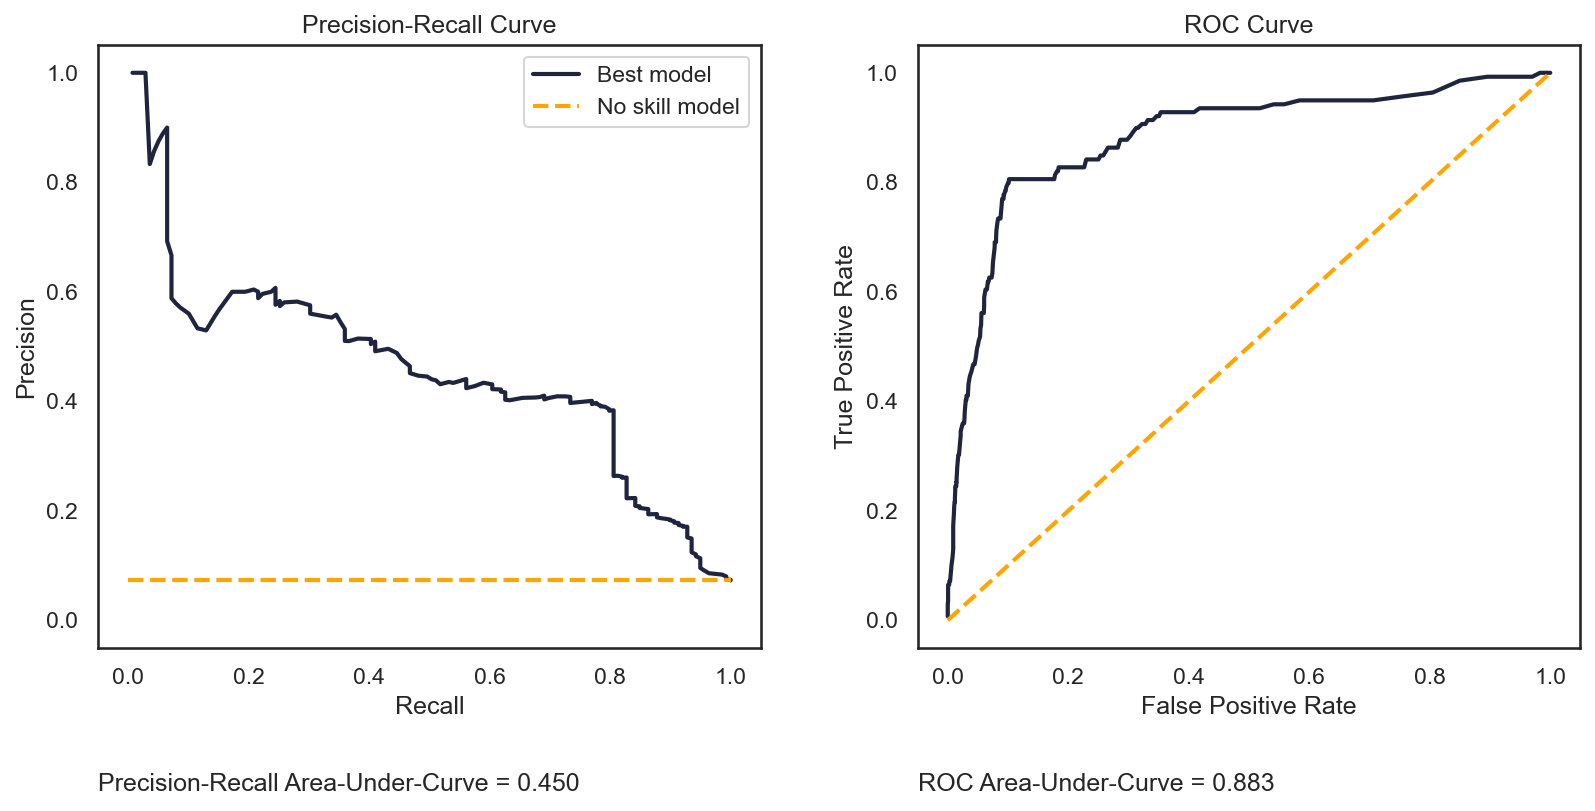

In [42]:
roc_auc_val = auc(fprs[0, :], tprs[0, :])
pr_auc_val = auc(recalls[0, :], precisions[0, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

axes[0].plot(
    recalls[0, :],
    precisions[0, :],
    marker="",
    label="Best model",
    color=pal[5],
    linewidth=2,
)

axes[0].plot(
    np.array([0, 1]),
    np.array([0.073, 0.073]),
    marker="",
    linestyle="--",
    label="No skill model",
    color="orange",
    linewidth=2,
)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text(
    x=-0.05,
    y=-0.3,
    s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(
    fprs[0, :], tprs[0, :], marker="", label="Best model", color=pal[5], linewidth=2,
)

axes[1].plot(
    np.array([0, 1]),
    np.array([0, 1]),
    marker="",
    linestyle="--",
    label="No skill",
    color="orange",
    linewidth=2,
)

axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(
    x=-0.05,
    y=-0.3,
    s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True, which="major")
    ax.grid(False)

plt.show()

In [43]:
final_best_threshold_mre = best_threshold
final_best_threshold_kl = best_threshold_kl

print('Approximate best threshold for Input Space: best_threshold_mre, ', final_best_threshold_mre)
print('Approximate best threshold for Latent Space: best_threshold_kl,', final_best_threshold_kl)

Approximate best threshold for Input Space: best_threshold_mre,  177.81655826174566
Approximate best threshold for Latent Space: best_threshold_kl, 45.580219997406026


The dashed lines in the above plots represent what a “no skilled model” would obtain if it was doing the anomaly detection — that is, if a model randomly assigned a class (normal or abnormal) to each sub-cut in the data set. This random model is represented by a diagonal line in the ROC plot, and a horizontal line, set at a precision 0.073 (the percentage of failed sub-cuts in the testing set), on the PR-AUC plot.

Compare the precision-recall curve and the ROC curve: the ROC curve gives a more optimistic view of the performance of the model; that is an area-under-curve of 0.883. However, the precision-recall area-under-curve is not nearly as high, with a value of 0.450.

Why the difference in area-under-curve values? It is because of the severe imbalance in our data set. This is the exact reason why you would want to use the PR-AUC instead of ROC-AUC metric. The PR-AUC will provide a more realistic view of a model’s performance when dealing with imbalanced data.